In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()
AUTOTUNE = tf.data.experimental.AUTOTUNE
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256,256, 3])
    return image
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
print(monet_ds)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [2]:
def generator_model():
    model =tf.keras.Sequential()
    input0= layers.Input(shape=(256,256,3))
    input1=layers.Conv2DTranspose(128,4,padding='same',strides=(1,1))(input0)
    input2=layers.BatchNormalization()(input1)
    input3=layers.LeakyReLU()(input2)
    
    input4=layers.UpSampling2D()(input3)
    input5=layers.Conv2D(256,4,padding='same',strides=(1,1))(input4)
    input6=layers.BatchNormalization()(input5)
    input7=layers.LeakyReLU()(input6)

    input8=layers.UpSampling2D()(input7)
    input9=layers.Conv2D(512,4,padding='same',strides=(2,2))(input8)
    input10=layers.BatchNormalization()(input9)
    input11=layers.LeakyReLU()(input10)

    input12=layers.Conv2D(512,4,padding='same',strides=(2,2))(input11)
    input13=layers.BatchNormalization()(input12)
    input14=layers.LeakyReLU()(input13)
    
    input15=layers.Conv2D(256,4,padding='same',strides=(1,1))(input14)
    input16=layers.BatchNormalization()(input15)
    input17=layers.LeakyReLU()(input16)
    
    input18=layers.Conv2D(128,4,padding='same',strides=(1,1))(input17)
    input19=layers.BatchNormalization()(input18)
    input20=layers.LeakyReLU()(input19)
    
    output=layers.Conv2D(3,4,padding='same',activation='sigmoid')(input20)
    return  tf.keras.Model(inputs=input0, outputs=output)

In [3]:
generator_monet=generator_model()
generator_photo=generator_model()
generated_image=generator_monet(next(iter(monet_ds)),training=False)

TensorShape([1, 256, 256, 3])

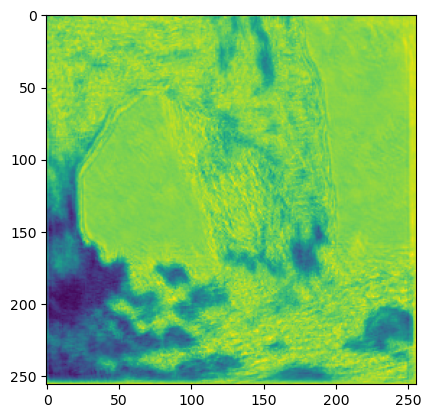

In [4]:
import matplotlib.pyplot as plt
plt.imshow(generated_image[0,:,:,0])
generated_image.shape

In [5]:
from tensorflow.keras.models import Model
def discrimatior_model():
    input0=layers.Input(shape=[256,256,3])
    input1=layers.Conv2D(128,4,strides=(1,1),padding='same')(input0)
    input2=layers.LeakyReLU()(input1)
    input3=layers.Dropout(0.2)(input2)
    
    input4=layers.Conv2D(128,4,strides=(1,1),padding='same')(input3)
    input5=layers.LeakyReLU()(input4)
    input6=layers.Dropout(0.2)(input5)
    
    input7=layers.Conv2D(256,4,strides=(2,2),padding='same')(input6)
    input8=layers.LeakyReLU()(input7)
    input9=layers.Dropout(0.2)(input8)

    input10=layers.ZeroPadding2D()(input9)
    input11=layers.Flatten()(input10)
    output=layers.Dense(1)(input11)
    return tf.keras.Model(inputs=input0, outputs=output)

In [6]:
discrimator=discrimatior_model()
print(discrimator(generated_image))

tf.Tensor([[0.0296491]], shape=(1, 1), dtype=float32)


In [7]:
monet_discrimator=discrimatior_model()
photo_discrimator=discrimatior_model()

In [8]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real,fake):
    real_loss=cross_entropy(tf.ones_like(real),real)
    fake_loss=cross_entropy(tf.zeros_like(fake),fake)
    loss=real_loss+fake_loss
    return loss
def generator_loss(fake):
    return cross_entropy(tf.zeros_like(fake),fake)
monet_generator_optimizer=tf.keras.optimizers.Adam(1e-4)
monet_discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)
photo_generator_optimizer=tf.keras.optimizers.Adam(1e-4)
photo_discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [9]:
def calc_cycle_loss(real_image, cycled_image):
    loss1=tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10 * loss1
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 5 * loss

In [10]:
@tf.function
def train_image(batch_data):
    real_monet,real_photo=batch_data
    with tf.GradientTape(persistent=True) as gen_tape,tf.GradientTape(persistent=True) as disc_tape:
        fake_monet=generator_monet(real_photo,training=True)
        cycled_photo=generator_photo(fake_monet,training=True)
        
        fake_photo=generator_photo(real_monet,training=True)
        cycled_monet=generator_monet(fake_photo,training=True)
        
        same_monet=generator_monet(real_monet,training=True)
        same_photo=generator_photo(real_photo,training=True)
        
        real_monet_output=monet_discrimator(same_monet,training=True)
        fake_monet_output=monet_discrimator(cycled_monet,training=True)
        
        real_photo_output=photo_discrimator(same_photo,training=True)
        fake_photo_output=photo_discrimator(cycled_photo,training=True)
        
#         total_cycle_loss = calc_cycle_loss(real_monet, cycled_monet) + calc_cycle_loss(real_photo, cycled_photo)
        
        monet_gen_loss=generator_loss(fake_monet_output)
        photo_gen_loss=generator_loss(fake_photo_output)
        
#         total_gen_g_loss = monet_loss + total_cycle_loss + identity_loss(real_monet, same_monet)
#         total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        monet_disc_loss=discriminator_loss(real_monet_output,fake_monet_output)
        photo_disc_loss=discriminator_loss(real_photo_output,fake_photo_output)
    gradients_monet_generator=gen_tape.gradient(monet_gen_loss,generator_monet.trainable_variables)
    gradients_photo_generator=gen_tape.gradient(photo_gen_loss,generator_photo.trainable_variables)
    gradients_monet_discrimator=disc_tape.gradient(monet_disc_loss,monet_discrimator.trainable_variables)
    gradients_photo_discrimator=disc_tape.gradient(photo_disc_loss,photo_discrimator.trainable_variables)
    
    monet_generator_optimizer.apply_gradients(zip(gradients_monet_generator,generator_monet.trainable_variables))
    monet_discriminator_optimizer.apply_gradients(zip(gradients_monet_discrimator,monet_discrimator.trainable_variables))
    photo_generator_optimizer.apply_gradients(zip(gradients_photo_generator,generator_photo.trainable_variables))
    photo_discriminator_optimizer.apply_gradients(zip(gradients_photo_discrimator,photo_discrimator.trainable_variables))


In [11]:
tf.__version__

'2.12.0'

In [12]:
import time
def train(epochs):
    for epoch in range(epochs):
        start=time.time()
        for batch in tf.data.Dataset.zip((monet_ds, photo_ds)):
            train_image(batch)

In [13]:
# checkpoint_path = "./kaggle/working/checkpoints/train"

# ckpt = tf.train.Checkpoint(generator_monet=generator_monet,
#                            generator_photo=generator_photo,
#                            monet_discrimator=monet_discrimator,
#                            photo_discrimator=photo_discrimator,
#                            monet_generator_optimizer=monet_generator_optimizer,
#                            photo_generator_optimizer=photo_generator_optimizer,
#                            monet_discriminator_optimizer=monet_discriminator_optimizer,
#                            photo_discriminator_optimizer=photo_discriminator_optimizer)

# ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if ckpt_manager.latest_checkpoint:
#     ckpt.restore(ckpt_manager.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [14]:
train(10)

2023-07-21 10:07:49.464572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_6/dropout_1/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


In [15]:
pred=generator_monet(next(iter(photo_ds)))


In [16]:
generator_monet.save("./kaggle/working/monetmodel.h5")
generator_photo.save("./kaggle/working/photomodel.h5")

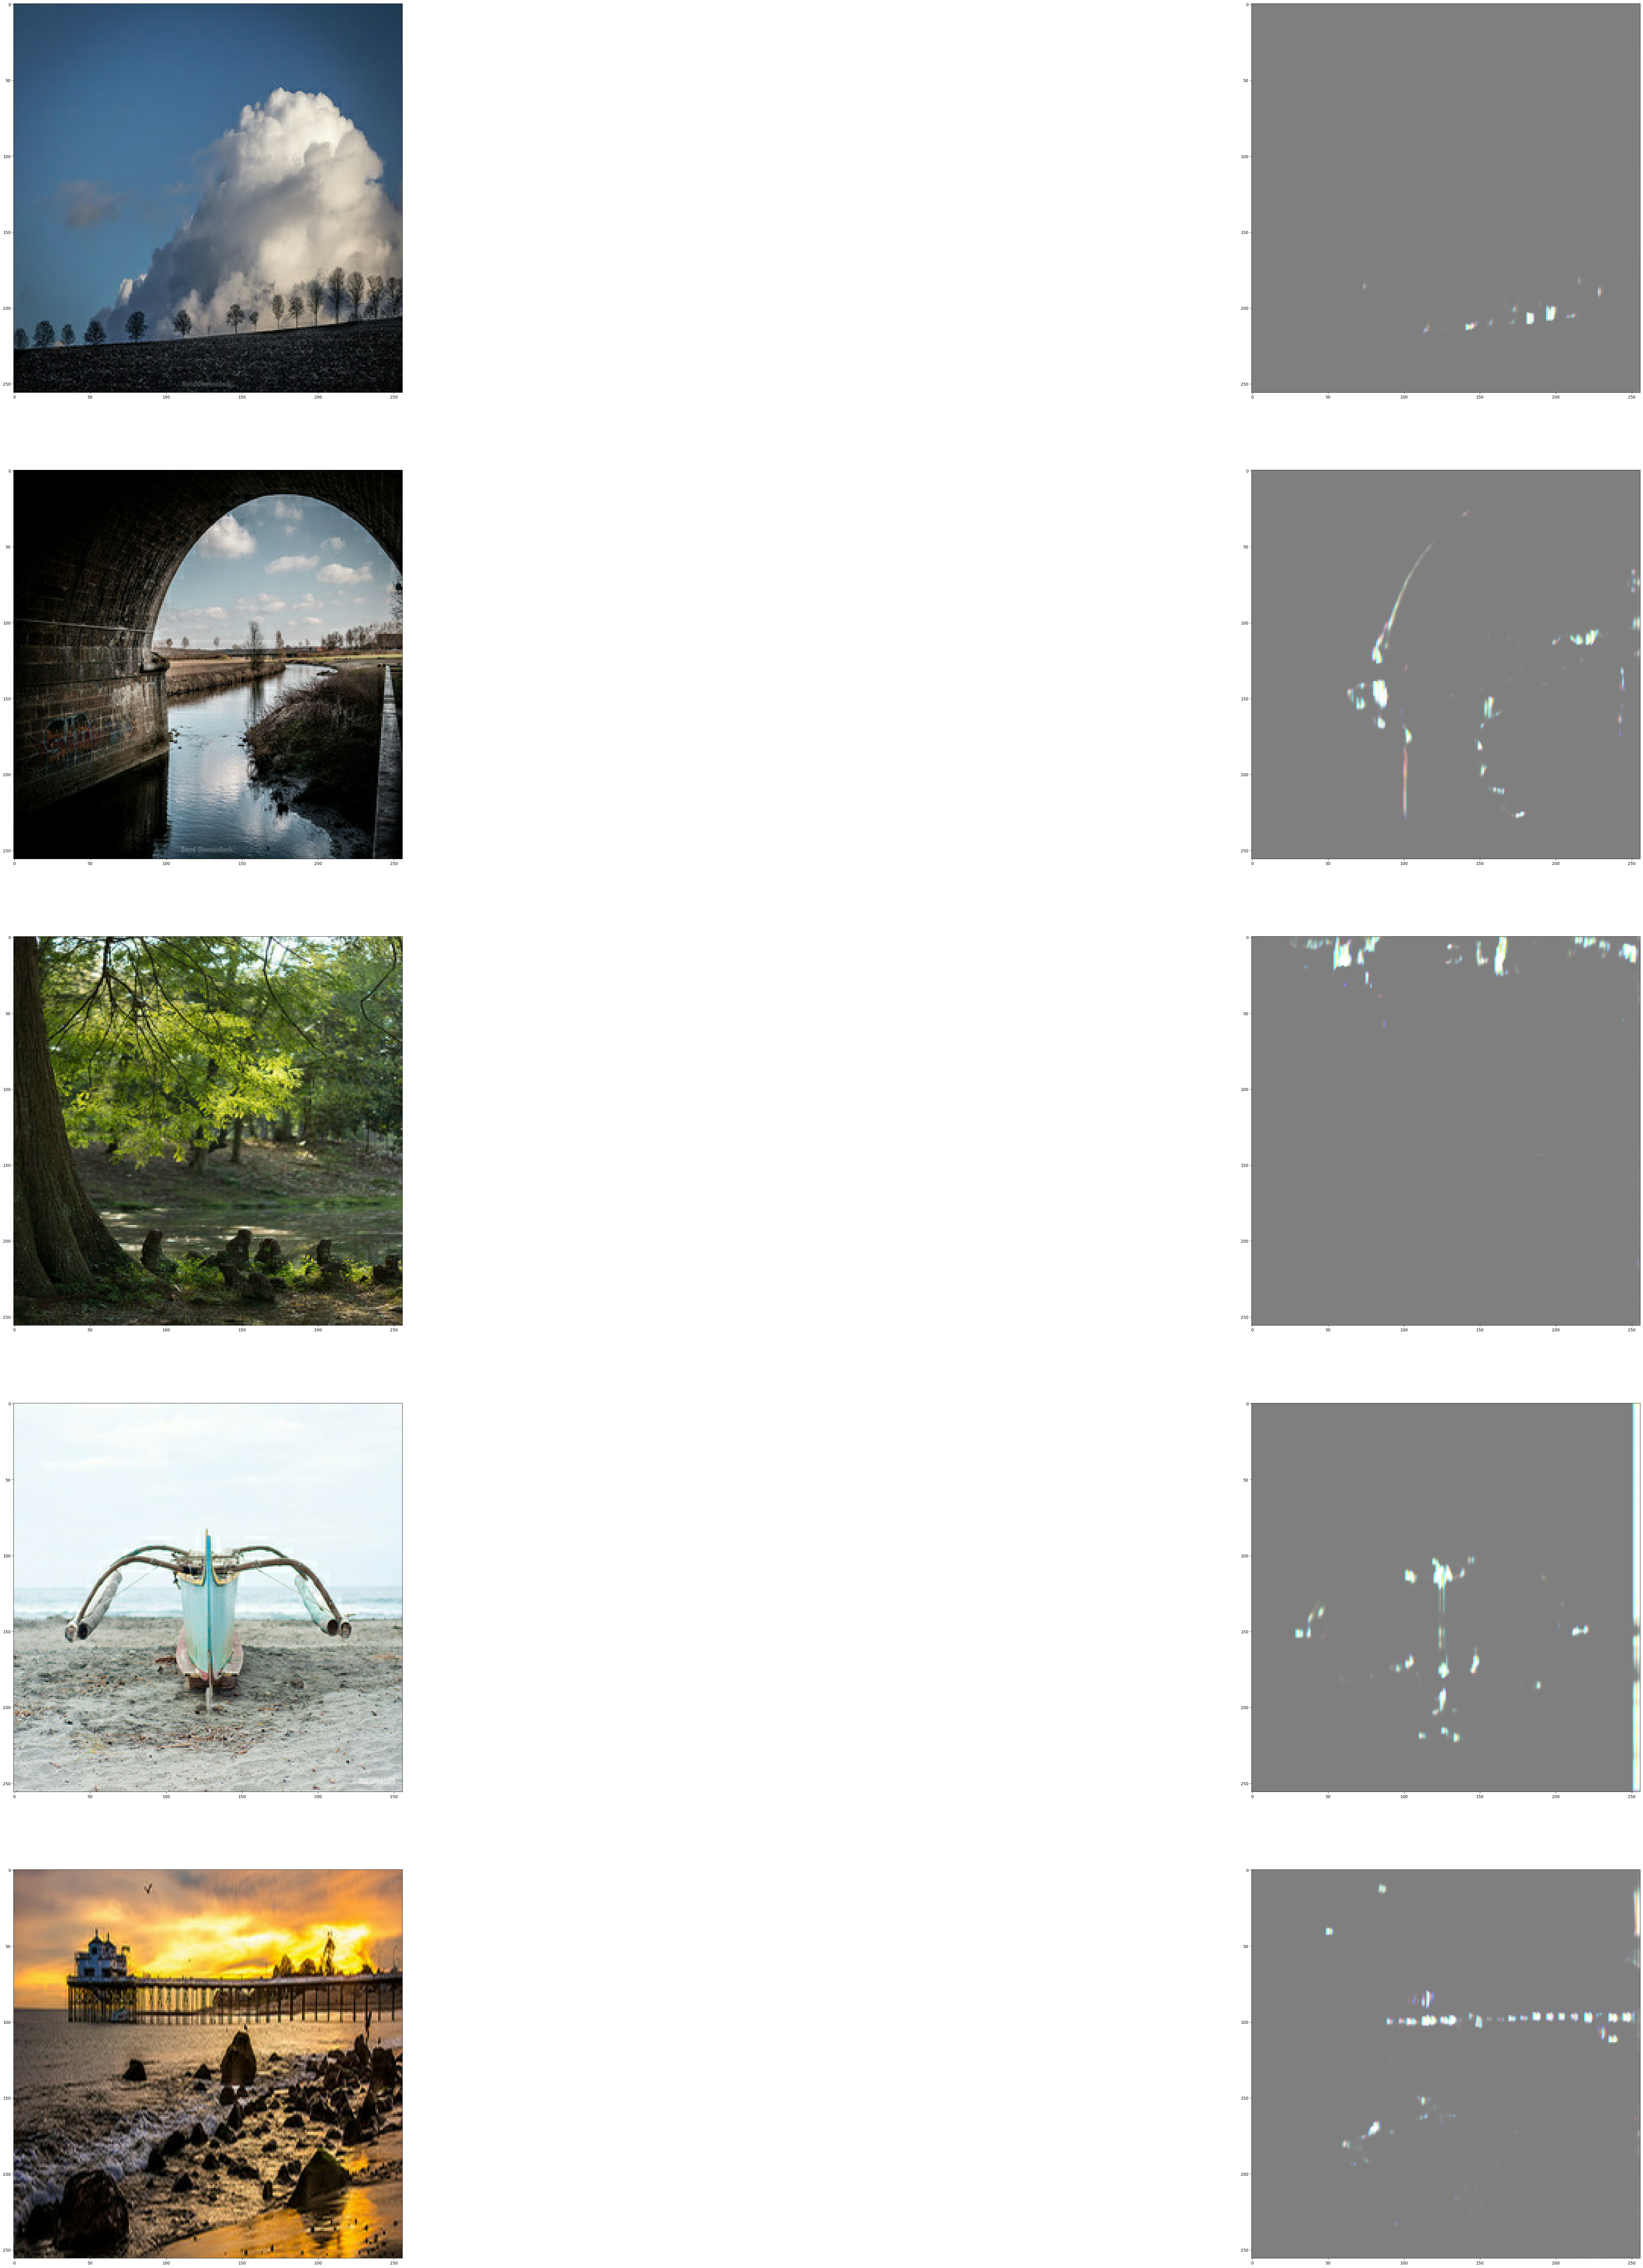

In [17]:
import numpy as np
_, ax = plt.subplots(5, 2, figsize=(100, 100))
for i, img in enumerate(photo_ds.take(5)):
    prediction = generator_monet(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)